# Informatin Retrival and Data Mining COMP0084 - Project Part 1
student id: 20031465

In [1]:
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

## 1. Text Statistics

In [2]:
def get_word_counts(file):
    with open(file, encoding='utf8') as f:
        text = f.read()
    words = re.findall(r'[a-z]+', text.lower())
    word_counts = pd.Series(words).value_counts().sort_values(ascending=False)
    words = word_counts.index.values 
    counts = word_counts.values
    return words, counts

file = './dataset/passage_collection_new.txt'
words, counts = get_word_counts(file)

# Drop words with too few occurrences
valid_words = counts > 3
counts = counts[valid_words]
words = words[valid_words]

In [3]:
from scipy.optimize import minimize_scalar

ranks = np.arange(counts.size) + 1

def neg_loglik(a):
    probs = 1 / ranks**a
    probs /= probs.sum()
    return -np.sum(np.log(probs) * counts)

a = minimize_scalar(neg_loglik).x
c = 1 / np.sum(1/ranks**a)
c_true = 1 / np.sum(1/ranks)

print('Power Law MLE:')
print(f'a: {np.round(a, 4)}, c: {np.round(c, 4)}')
print("Zipf's law MLE:")
print(f'c: {np.round(c_true, 4)}')

Power Law MLE:
a: 1.0156, c: 0.0953
Zipf's law MLE:
c: 0.0881


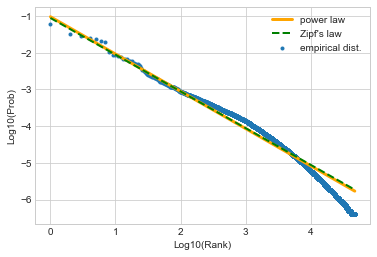

In [4]:
n = len(counts)
ranks = np.arange(n) + 1
x = np.log10(ranks)
probs = counts / counts.sum()

powerlaw = np.log10(c) - a*np.log10(ranks)
plt.plot(x, powerlaw, color='orange', label='power law', linewidth=3)

zipfslaw = np.log10(c_true) - np.log10(ranks)
plt.plot(x, zipfslaw, color='green', label="Zipf's law", linewidth=2, ls='--')

plt.scatter(x, np.log10(probs), marker='.',label='empirical dist.')

plt.legend()
plt.xlabel('Log10(Rank)')
plt.ylabel('Log10(Prob)')
plt.savefig('zipfslaw.jpg', dpi=300, bbox_inches='tight')

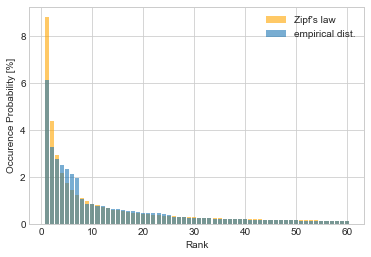

In [5]:
probs = counts / counts.sum() * 100
r = np.arange(1, 61)
zipfslaw = 100 * c_true / r
plt.bar(r, zipfslaw, alpha=0.6, label="Zipf's law", color='orange')
plt.bar(r, probs[:60], alpha=0.6, label='empirical dist.')
plt.xlabel('Rank')
plt.ylabel('Occurence Probability [%]')
plt.legend()
plt.savefig('word_dist.jpg', dpi=300, bbox_inches='tight')

In [6]:
zips_df = pd.DataFrame({'Word': words, 'Freq': counts, 'r': ranks})
zips_df['Pr(%)'] = counts / counts.sum() * 100
zips_df['r*Pr'] = zips_df['r'] * zips_df['Pr(%)'] / 100
zips_df.head(10)

,Word,Freq,r,Pr(%),r*Pr
0,the,626948,1,6.158419,0.061584
1,of,334311,2,3.283888,0.065678
2,a,284646,3,2.796036,0.083881
3,and,255232,4,2.507107,0.100284
4,to,240995,5,2.367259,0.118363
5,is,216885,6,2.130430,0.127826
6,in,202270,7,1.986869,0.139081
7,for,108171,8,1.062548,0.085004
8,or,86935,9,0.853950,0.076855
9,you,86662,10,0.851268,0.085127


## 2. Inverted Index

In [7]:
class Preprocessor:
    def __init__(self, 
                 pattern=re.compile(r'[\w]+'),
                 stopwords=nltk.corpus.stopwords.words('english'),
                 stemmer=nltk.stem.PorterStemmer()):
        self.pattern = pattern
        self.stopwords = set(stopwords)
        self.stemmer = stemmer
        
    def transform(self, text):
        tokens = self.tokenize(text)
        if self.stopwords is not None:
            tokens = self.remove_stopwords(tokens)
        if self.stemmer is not None:
            tokens = self.stem(tokens)
        return self.get_bow(tokens)
    
    def tokenize(self, text):
        return self.pattern.findall(text.lower())
    
    def remove_stopwords(self, tokens):
        return [tkn for tkn in tokens if tkn not in self.stopwords]
    
    def stem(self, tokens):
        return [self.stemmer.stem(tkn) for tkn in tokens]
    
    def get_bow(self, tokens):
        return dict(Counter(tokens))
    
    
class InvertedIndex:
    def __init__(self, pids, passages, preprocessor=Preprocessor()):
        self.index = dict()
        self.corpus = dict()
        self.preprocessor = preprocessor
        
        self.corpus_len = len(pids)
        self.corpus_size = 0
        self.vocab_size = 0
        self.avg_psg_len = 0
        
        psgs_bow = list(map(preprocessor.transform, passages))
        self.build(pids, psgs_bow)
        
    def build(self, pids, psgs_bow):
        for pid, psg_bow in zip(pids, psgs_bow):
            self.extend_index(pid, psg_bow)
            self.extend_corpus(pid, psg_bow)
        self.vocab_size = len(self.index)
        self.avg_psg_len = self.corpus_size / self.corpus_len
    
    def extend_index(self, pid, psg_bow):
        for token, cnt in psg_bow.items():
            self.index.setdefault(token,
                                  {'num_psgs':0,
                                   'corpus_count':0,
                                   'pids':[]})
            self.index[token]['num_psgs'] += 1
            self.index[token]['corpus_count'] += cnt
            self.index[token]['pids'].append(pid)
    
    def extend_corpus(self, pid, psg_bow):
        length = sum(psg_bow.values())
        self.corpus_size += length
        self.corpus[pid] = {
            'bow': psg_bow,
            'len': length
        }
    
    def retrieve(self, query):
        tokens = self.preprocessor.transform(query).keys()
        pids = []
        for token in tokens:
            if token in self.index:
                pids += self.get_pids(token)
        return set(pids)
    
    def get_pids(self, token):
        return self.index[token]['pids']
    
    def get_num_psgs(self, token):
        return self.index[token]['num_psgs']
    
    def get_corpus_count(self, token):
        return self.index[token]['corpus_count']
        
    def get_psg_len(self, pid):
        return self.corpus[pid]['len']
    
    def get_psg_bow(self, pid):
        return self.corpus[pid]['bow']
    
    def get_psg_count(self, token, pid):
        return self.corpus[pid]['bow'][token]
    
    def is_invocab(self, token):
        return token in self.index

## 3. Retrieval Model

In [8]:
class VSM:
    def __init__(self, index):
        self.index = index
        self.preprocessor = index.preprocessor
    
    def rank(self, query):
        pids = self.index.retrieve(query)
        query_bow = self.preprocessor.transform(query)
        query_bow = self.safe_query(query_bow)
        q_vec = self.get_tfidf_vec(query_bow)
        scores = []
        for pid in pids:
            p_vec = self.get_tfidf_vec(self.index.get_psg_bow(pid))
            scores.append([self.score(q_vec, p_vec), pid])
        return sorted(scores, reverse=True)
    
    def get_tfidf_vec(self, bow):
        tokens, freq = bow.keys(), list(bow.values())
        tf = 1 + np.log(freq)
        df = np.zeros(len(tokens))
        for i, token in enumerate(tokens):
            df[i] = self.index.get_num_psgs(token)
        idf = 1 + np.log(self.index.corpus_len/df)
        tfidf = tf * idf
        norm = np.linalg.norm(tfidf)
        if norm != 0:
            tfidf /=  norm
        return dict(zip(tokens, tfidf))
    
    @staticmethod
    def score(q_vec, p_vec):
        result = 0
        for token, val in q_vec.items():
            if token in p_vec:
                result += p_vec[token] * val
        return result
    
    def safe_query(self, query_bow):
        bad_tokens = []
        for token in query_bow:
            if not self.index.is_invocab(token):
                bad_tokens.append(token)
        for token in bad_tokens:
            del query_bow[token]
        return query_bow
    

class BM25:
    def __init__(self, index, k1=1.2, k2=100, b=0.75):
        self.index = index
        self.preprocessor = index.preprocessor
        self.k1 = k1
        self.k2 = k2
        self.b = b
    
    def rank(self, query):
        pids = self.index.retrieve(query)
        query_bow = self.preprocessor.transform(query)
        query_bow = self.safe_query(query_bow)
        q_term = self.get_query_term(query_bow)
        scores = []
        for pid in pids:
            scores.append([self.score(pid, query_bow, q_term), pid])
        return sorted(scores, reverse=True)
        
    def score(self, pid, query_bow, q_term):
        k1 = self.k1
        k2 = self.k2
        b = self.b
        avgpl = self.index.avg_psg_len
        pl = self.index.get_psg_len(pid)
        psg_bow = self.index.get_psg_bow(pid)
        score = 0
        for q in query_bow:
            if q in psg_bow:
                f = psg_bow[q]
                term2 = f * (k1+1) / (f + k1*(1 - b + b*pl/avgpl))
                score += q_term[q] * term2
        return score
    
    def get_query_term(self, query_bow):
        n_psgs = self.index.corpus_len
        k2 = self.k2
        q_term = dict()
        for q, qf in query_bow.items():
            n = self.index.get_num_psgs(q)
            term3 = (k2+1) * qf / (k2+qf)
            idf = np.log((n_psgs-n+0.5) / (n+0.5))
            q_term[q] = idf * term3
        return q_term
        
    def safe_query(self, query_bow):
        bad_tokens = []
        for token in query_bow:
            if not self.index.is_invocab(token):
                bad_tokens.append(token)
        for token in bad_tokens:
            del query_bow[token]
        return query_bow

## 4. Language Modelling

In [9]:
class LanguageModel:
    def __init__(self, index):
        self.index = index
        self.preprocessor = index.preprocessor
        
    def rank(self, query):
        pids = self.index.retrieve(query)
        query_bow = self.preprocessor.transform(query)
        query_bow = self.safe_query(query_bow)
        scores = []
        for pid in pids:
            scores.append([self.score(pid, query_bow), pid])
        return sorted(scores, reverse=True)
        
    def score(self, pid, query_bow):
        psg_bow = self.index.get_psg_bow(pid)
        psg_len = self.index.get_psg_len(pid)
        score = 0
        for q in query_bow:
            if q in psg_bow:
                m = psg_bow[q]
                score += np.log((m) / psg_len)
            else:
                score += -np.inf
        return score
    
    def safe_query(self, query_bow):
        bad_tokens = []
        for token in query_bow:
            if not self.index.is_invocab(token):
                bad_tokens.append(token)
        for token in bad_tokens:
            del query_bow[token]
        return query_bow

    
class LaplaceLM(LanguageModel):
    def score(self, pid, query_bow):
        psg_bow = self.index.get_psg_bow(pid)
        psg_len = self.index.get_psg_len(pid)
        vocab_size = self.index.vocab_size
        score = 0
        denominator = psg_len + vocab_size
        for q in query_bow:
            if q in psg_bow:
                m = psg_bow[q]
            else:
                m = 0
            score += np.log((m+1) / denominator)
        return score
    
    
class DirichletLM(LanguageModel):
    def __init__(self, index, mu=2000):
        super().__init__(index)
        self.mu = mu

    def score(self, pid, query_bow):
        mu = self.mu
        psg_bow = self.index.get_psg_bow(pid)
        psg_len = self.index.get_psg_len(pid)
        corpus_size = self.index.corpus_size
        score = 0
        const1 = psg_len / (psg_len+mu)
        const2 = mu / (psg_len+mu)
        for q in query_bow:
            if q in psg_bow:
                m = psg_bow[q]
            else:
                m = 0
            p_prob = m / psg_len
            c_prob = self.index.get_corpus_count(q) / corpus_size
            score += np.log(const1*p_prob + const2*c_prob)
        return score
    
    
class LidstoneLM(LanguageModel):
    def __init__(self, index, epsilon=0.5):
        super().__init__(index)
        self.epsilon = epsilon

    def score(self, pid, query_bow):
        epsilon = self.epsilon
        psg_bow = self.index.get_psg_bow(pid)
        psg_len = self.index.get_psg_len(pid)
        vocab_size = self.index.vocab_size
        score = 0
        denominator = psg_len + epsilon*vocab_size
        for q in query_bow:
            if q in psg_bow:
                m = psg_bow[q]
            else:
                m = 0
            score += np.log((m+epsilon) / denominator)
        return score

## Save Results

In [10]:
def save_ranking(algoname, Model, q_map, q_index):
    with open(algoname+'.txt', 'w') as f:
        for qid, query in q_map.items():
            ranking = Model(q_index[qid]).rank(query)
            for i, (score, pid) in enumerate(ranking[:100]):
                rank = i+1
                line = f'{qid} A1 {pid} {rank} {score} {algoname}\n'
                f.write(line)

In [11]:
path = './dataset/candidate_passages_top1000.tsv'
names = ['qid', 'pid', 'query', 'passage']
df = pd.read_csv(path, sep='\t', header=None, names=names)
df.head()

,qid,pid,query,passage
0,494835,7130104,"sensibilities, definition",This is the definition of RNA along with examp...
1,1128373,7130104,iur definition,This is the definition of RNA along with examp...
2,131843,7130104,definition of a sigmet,This is the definition of RNA along with examp...
3,20455,7130335,ar glasses definition,Best Answer: The AR designation comes from the...
4,719381,7130335,what is ar balance,Best Answer: The AR designation comes from the...


In [12]:
q_map = dict()
q_index = dict()
for qid in df['qid'].unique():
    q_df = df[df['qid']==qid]
    q_map[qid] = q_df['query'].values[0]
    q_index[qid] = InvertedIndex(q_df['pid'].values, q_df['passage'].values)

In [13]:
algos = [
    ('VS', VSM),
    ('BM25', BM25),
    ('LM-Dirichlet', DirichletLM),
    ('LM-Laplace', LaplaceLM),
    ('LM-Lidstone', LidstoneLM)
]

for algoname, Algo in algos:
    save_ranking(algoname, Algo, q_map, q_index)